### Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

# a. Набор данных

Данные https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

Датасет, содержащий изображения различных сцен (город, природа, сельская местность, леса), для выполнения многоклассовой классификации.

Практическая обоснованность:Модель, обученная на этом датасете, применима для  анализа ландшафта и автоматической категоризации изображений для городского планирования и мониторинга окружающей среды.

In [1]:
!pip install kaggle

In [3]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kirillzhur
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


Найдено классов: 6 - ['street', 'glacier', 'forest', 'sea', 'mountain', 'buildings']


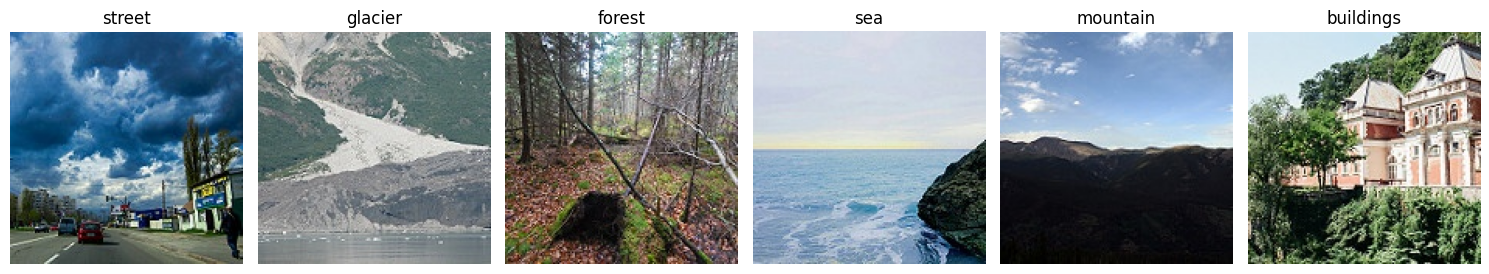

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


data_dir = '/content/intel-image-classification/seg_train/seg_train'


classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Найдено классов: {len(classes)} - {classes}")


sample_images = []
sample_labels = []
for cls in classes:
    img_paths = glob.glob(os.path.join(data_dir, cls, '*.jpg'))
    if img_paths:
        sample_img = random.choice(img_paths)
        sample_images.append(sample_img)
        sample_labels.append(cls)


n_classes = len(sample_images)


plt.figure(figsize=(15, 5))
for i, (img_path, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(1, n_classes, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# b. Метрики качества


В качестве метрик для этой задачи будем использовать Accuracy = (TP + TN) / (TP + TN + FP + FN) и F1-score = 2 * (presicion * recall) / (presicion + recall)

Данные метрики подойдут, поскольку accuracy покажет долю правильно предсказанных изображений от общего числа. F1-score позволяет более детально оценить, как модель справляется с каждым классом.


Также будем строить Confusion Matrix для  визуализизации, какие классы наиболее часто путаются между собой, чтобы выявить слабые места модели и скорректировать гиперпараметры или провести дополнительные эксперименты с аугментацией.

## 2. Создание бейзлана и оценка качества


В качестве сверточной модели будем использовать предварительно обученная модель ResNet18, в которую заменяется последний слой под количество классов.

In [6]:
import time
import copy
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Задаём трансформации (одинаковые для train и val)
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = '/content/intel-image-classification/seg_train/seg_train'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
print(f"Всего изображений: {len(full_dataset)}")
print(f"Классы: {full_dataset.classes}")

# Разделим датасет на train и val ( 80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

Всего изображений: 14034
Классы: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Используем устройство: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Обучение завершено за {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Лучшая точность на валидации: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, all_preds, all_labels

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


Epoch 1/5
----------
train Loss: 0.5068 Acc: 0.8155
val Loss: 0.3519 Acc: 0.8671

Epoch 2/5
----------
train Loss: 0.3428 Acc: 0.8765
val Loss: 0.3286 Acc: 0.8778

Epoch 3/5
----------
train Loss: 0.3122 Acc: 0.8899
val Loss: 0.3170 Acc: 0.8885

Epoch 4/5
----------
train Loss: 0.2947 Acc: 0.8923
val Loss: 0.3031 Acc: 0.8967

Epoch 5/5
----------
train Loss: 0.2786 Acc: 0.9015
val Loss: 0.3091 Acc: 0.8856

Обучение завершено за 3m 51s
Лучшая точность на валидации: 0.8967
Validation Accuracy: 0.8831
Validation F1 Score: 0.8827


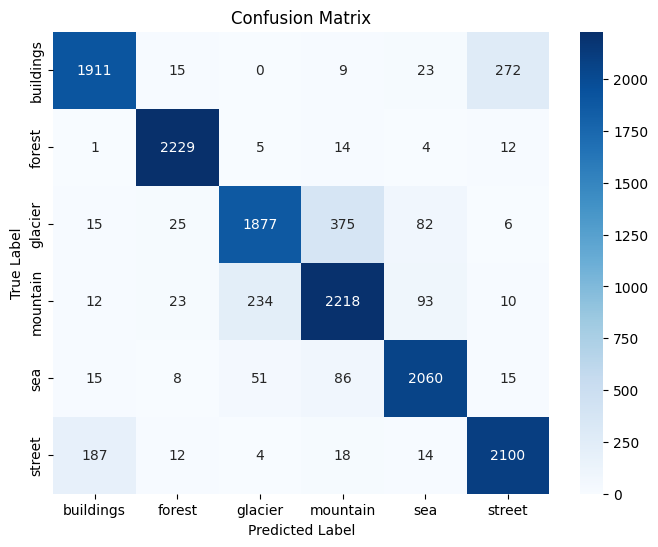

In [ ]:
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv, preds, true_labels = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

val_accuracy = accuracy_score(true_labels, preds)
val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

В качестве трансфомерной модели будем использовать предварительно обученная модель ViT-B/16, в которую заменяется последний слой под количество классов. Обучим на 3 эпохах а не на 5 так как ждать обучения приходится дольше

Трансформерная модель
Epoch 1/3
----------
train Loss: 0.4023 Acc: 0.8600
val Loss: 0.3148 Acc: 0.8807

Epoch 2/3
----------
train Loss: 0.2606 Acc: 0.9019
val Loss: 0.2960 Acc: 0.8913

Epoch 3/3
----------
train Loss: 0.2359 Acc: 0.9133
val Loss: 0.2735 Acc: 0.9013

Обучение завершено за 20m 4s
Лучшая точность на валидации: 0.9013
Validation Accuracy Transform model: 0.8911
Validation F1 Score Transform model: 0.8908


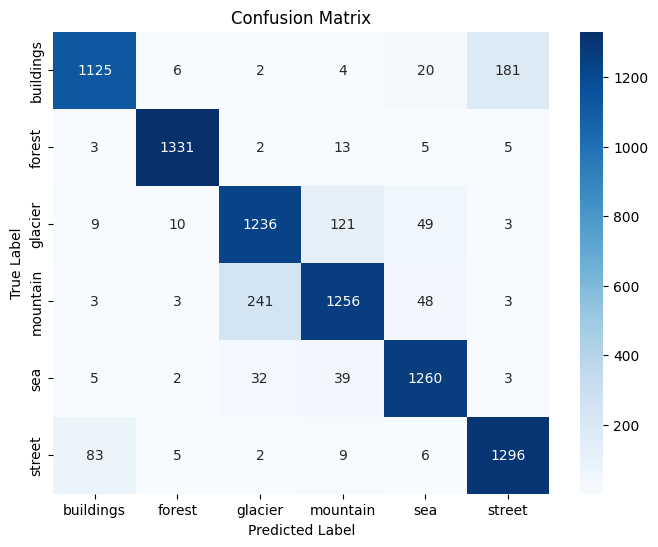

In [ ]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)

print("Трансформерная модель")
model_vit, preds, true_labels = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler, num_epochs=3)

val_accuracy = accuracy_score(true_labels, preds)
val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation Accuracy Transform model: {val_accuracy:.4f}')
print(f'Validation F1 Score Transform model: {val_f1:.4f}')


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 3. Улучшение бейзлайна

для улучшения бейзлайна добавим дополнительные техники аугментации (изменение яркости/контрастности, случайное вращение, цветовой сдвиг) что позволит модели лучше обобщать и повысит точность, так как данные станут более разнообразными.

In [ ]:
# Улучшенные трансформации для обучающей выборки
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

improved_transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_dir = '/content/intel-image-classification/seg_train/seg_train'
full_dataset = datasets.ImageFolder(data_dir, transform=improved_transforms_train)


total_size = len(full_dataset)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = improved_transforms_val


from torch.utils.data import DataLoader
batch_size = 32
dataloaders_improved = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes_improved = {x: len(dataloaders_improved[x].dataset) for x in ['train', 'val']}
class_names = full_dataset.classes
num_classes = len(class_names)


Epoch 1/10
----------
train Loss: 0.5680 Acc: 0.7912
val Loss: 0.5568 Acc: 0.7898

Epoch 2/10
----------
train Loss: 0.4566 Acc: 0.8310
val Loss: 0.5334 Acc: 0.8058

Epoch 3/10
----------
train Loss: 0.4255 Acc: 0.8453
val Loss: 0.3961 Acc: 0.8489

Epoch 4/10
----------
train Loss: 0.3984 Acc: 0.8584
val Loss: 0.3823 Acc: 0.8507

Epoch 5/10
----------
train Loss: 0.3854 Acc: 0.8601
val Loss: 0.4342 Acc: 0.8379

Epoch 6/10
----------
train Loss: 0.3788 Acc: 0.8606
val Loss: 0.4600 Acc: 0.8386

Epoch 7/10
----------
train Loss: 0.3648 Acc: 0.8668
val Loss: 0.4283 Acc: 0.8461

Epoch 8/10
----------
train Loss: 0.2849 Acc: 0.8966
val Loss: 0.3062 Acc: 0.8871

Epoch 9/10
----------
train Loss: 0.2508 Acc: 0.9081
val Loss: 0.2966 Acc: 0.8928

Epoch 10/10
----------
train Loss: 0.2450 Acc: 0.9086
val Loss: 0.2994 Acc: 0.8874

Обучение завершено за 7m 55s
Лучшая точность на валидации: 0.8928
Validation Accuracy (Improved): 0.8485
Validation F1 Score (Improved): 0.8480


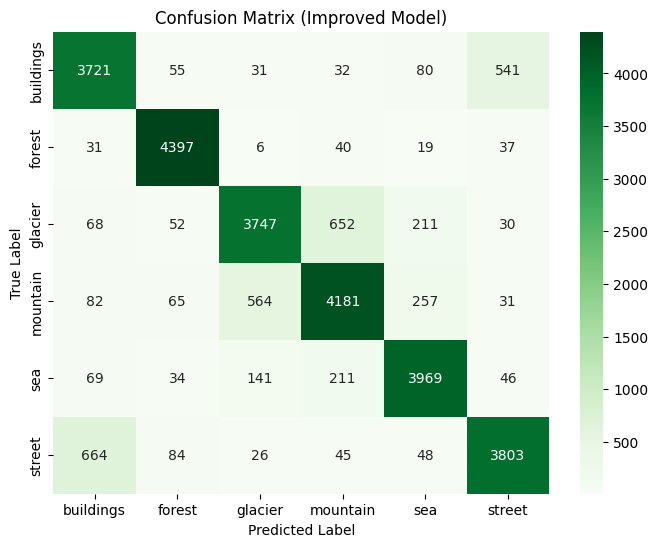

In [ ]:
model_improved = models.resnet18(pretrained=True)
num_ftrs = model_improved.fc.in_features
model_improved.fc = nn.Linear(num_ftrs, num_classes)
model_improved = model_improved.to(device)

criterion = nn.CrossEntropyLoss()
# оптимизатор Adam с другим learning rate
optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.0005)
exp_lr_scheduler_improved = lr_scheduler.StepLR(optimizer_improved, step_size=7, gamma=0.1)

#(num_epochs = 10)
model_improved, preds_improved, labels_improved = train_model(model_improved,
                                                              criterion,
                                                              optimizer_improved,
                                                              exp_lr_scheduler_improved,
                                                              num_epochs=10)

val_accuracy_improved = accuracy_score(labels_improved, preds_improved)
val_f1_improved = f1_score(labels_improved, preds_improved, average='weighted')
print(f'Validation Accuracy (Improved): {val_accuracy_improved:.4f}')
print(f'Validation F1 Score (Improved): {val_f1_improved:.4f}')

cm_improved = confusion_matrix(labels_improved, preds_improved)
plt.figure(figsize=(8,6))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Improved Model)')
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Трансформерная модель
Epoch 1/3
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.1410 Acc: 0.5307
val Loss: 0.9149 Acc: 0.6377

Epoch 2/3
----------
train Loss: 0.8467 Acc: 0.6720
val Loss: 0.7896 Acc: 0.6918

Epoch 3/3
----------
train Loss: 0.7192 Acc: 0.7265
val Loss: 0.7237 Acc: 0.7260

Обучение завершено за 20m 18s
Лучшая точность на валидации: 0.7260
Validation Accuracy (Improved): 0.6852
Validation F1 Score (Improved): 0.6799


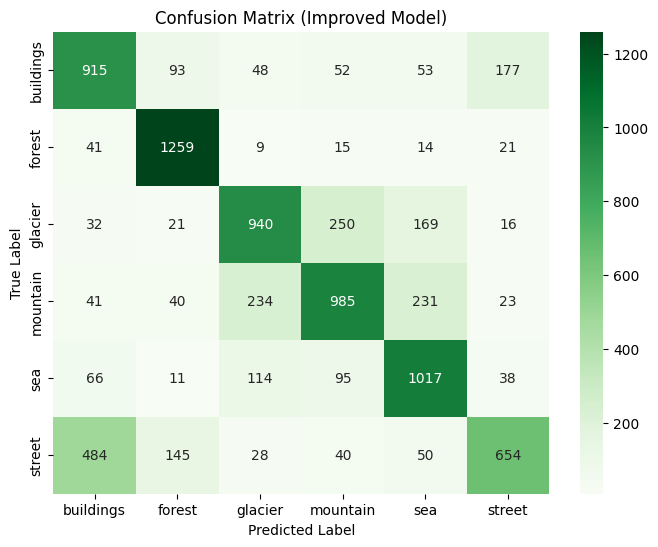

In [ ]:
model_vit_improved = models.vit_b_16(pretrained=True)
model_vit_improved.heads.head = nn.Linear(model_vit_improved.heads.head.in_features, num_classes)
model_vit_improved = model_vit_improved.to(device)

criterion = nn.CrossEntropyLoss()
# оптимизатор Adam с другим learning rate
optimizer_improved = optim.Adam(model_vit_improved.parameters(), lr=0.0005)
exp_lr_scheduler_improved = lr_scheduler.StepLR(optimizer_improved, step_size=7, gamma=0.1)

# num_epochs = 3
print("Трансформерная модель")
model_vit_improved, preds_improved, labels_improved = train_model(model_vit_improved,
                                                              criterion,
                                                              optimizer_improved,
                                                              exp_lr_scheduler_improved,
                                                              num_epochs=3)

val_accuracy_improved = accuracy_score(labels_improved, preds_improved)
val_f1_improved = f1_score(labels_improved, preds_improved, average='weighted')
print(f'Validation Accuracy (Improved): {val_accuracy_improved:.4f}')
print(f'Validation F1 Score (Improved): {val_f1_improved:.4f}')

cm_improved = confusion_matrix(labels_improved, preds_improved)
plt.figure(figsize=(8,6))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Improved Model)')
plt.show()


**Как видно из сравнения результатов добавление дополнительных техник аугментации и более тщательный подбор гиперпараметров (смена оптимизатора, снижение learning rate, увеличение числа эпох) позволили модели  resnet лучше обобщать, что подтверждается ростом accuracy и F1-score. К сожалению из-за долгого времени обучения я не смог увеличить число эпох у трансформерной модели, чтобы убедиться и на ней с ростом accuracy и F1-score**

## 4.	Имплементация алгоритма машинного обучения

Сначала реализуем свою сверточную модель

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")


#приводим изображения к размеру 300x300, нормализуем
train_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_dir = '/content/intel-image-classification/seg_train/seg_train'
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
print(f"Всего изображений: {len(full_dataset)}")
print(f"Классы: {full_dataset.classes}")


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes
num_classes = len(class_names)

Используем устройство: cuda:0
Всего изображений: 14034
Классы: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                              


            nn.Conv2d(32, 32, kernel_size=3, padding=1),   
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               


            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              


            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                                
        )
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

model_custom = CustomCNN(num_classes=num_classes).to(device)
print(model_custom)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15)

Epoch 1/5
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.0755 Acc: 0.5654
val Loss: 0.7826 Acc: 0.7214

Epoch 2/5
----------
train Loss: 0.6825 Acc: 0.7449
val Loss: 0.6335 Acc: 0.7788

Epoch 3/5
----------
train Loss: 0.5631 Acc: 0.7953
val Loss: 0.5600 Acc: 0.7923

Epoch 4/5
----------
train Loss: 0.5038 Acc: 0.8185
val Loss: 0.4981 Acc: 0.8219

Epoch 5/5
----------
train Loss: 0.4496 Acc: 0.8397
val Loss: 0.5071 Acc: 0.8212

Training complete in 8m 37s
Best val Acc: 0.8219
CNN Validation Accuracy: 0.7871
CNN Validation F1 Score: 0.7867


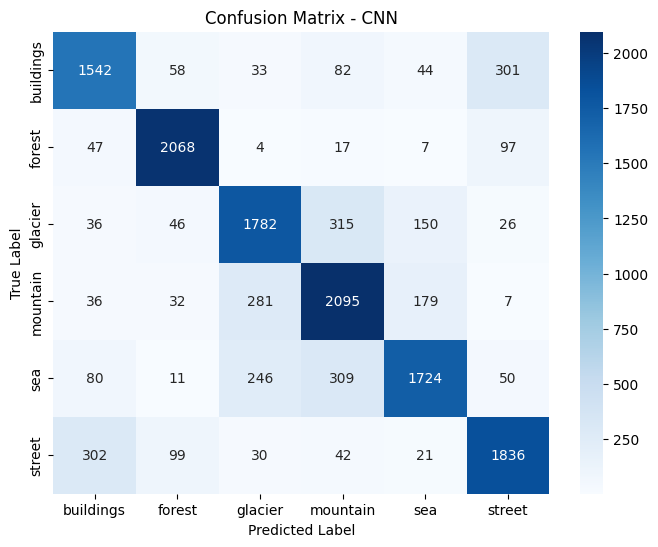

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, all_preds, all_labels

num_epochs = 5
model_custom, preds_cnn, labels_cnn = train_model(model_custom, criterion, optimizer, scheduler, num_epochs=num_epochs)

acc_cnn = accuracy_score(labels_cnn, preds_cnn)
f1_cnn = f1_score(labels_cnn, preds_cnn, average='weighted')
print(f'CNN Validation Accuracy: {acc_cnn:.4f}')
print(f'CNN Validation F1 Score: {f1_cnn:.4f}')

cm_cnn = confusion_matrix(labels_cnn, preds_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN')
plt.show()

In [8]:
class CustomTransformer(nn.Module):
    def __init__(self, image_size=300, patch_size=20, in_channels=3, num_classes=6,
                 embed_dim=256, num_heads=8, depth=8, dropout=0.1):

        super(CustomTransformer, self).__init__()
        assert image_size % patch_size == 0
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size


        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)


        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dropout=dropout, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)


        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x имеет форму (B, C, H, W)
        B, C, H, W = x.shape

        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().permute(0, 2, 3, 1, 4, 5)
        patches = patches.contiguous().view(B, -1, self.patch_dim)


        patch_embeddings = self.patch_embedding(patches)


        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, patch_embeddings), dim=1)


        x = x + self.pos_embedding
        x = self.dropout(x)


        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)


        x = x[0]
        x = self.mlp_head(x)
        return x



model_transformer = CustomTransformer(image_size=300, patch_size=20, in_channels=3,
                                                 num_classes=num_classes, embed_dim=256,
                                                 num_heads=8, depth=8, dropout=0.1).to(device)
print(model_transformer)


CustomTransformer(
  (patch_embedding): Linear(in_features=1200, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=256, bias

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/3
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.8291 Acc: 0.1833
val Loss: 1.8241 Acc: 0.1967

Epoch 2/3
----------
train Loss: 1.8289 Acc: 0.1821
val Loss: 1.8241 Acc: 0.1967

Epoch 3/3
----------
train Loss: 1.8290 Acc: 0.1822
val Loss: 1.8241 Acc: 0.1967

Training complete in 4m 40s
Best val Acc: 0.1967
Моя трансформерная модель
Transformer Validation Accuracy: 0.1967
Transformer Validation F1 Score: 0.0808


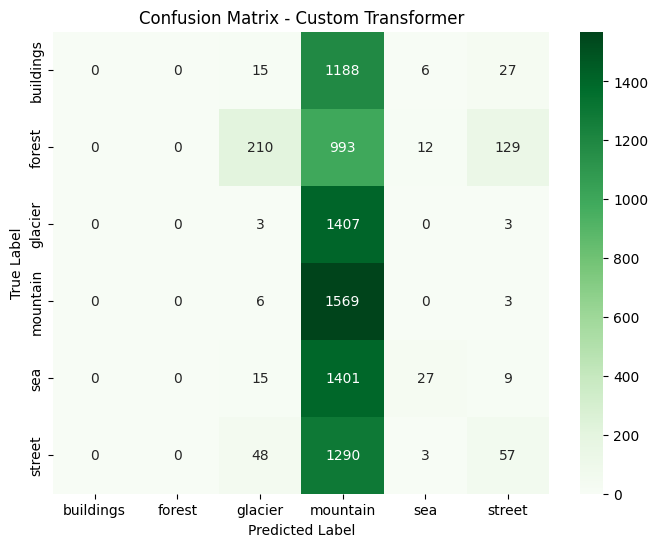

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=0.0005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


num_epochs = 3
model_transformer, preds_transformer, labels_transformer = train_model(model_transformer, criterion, optimizer, scheduler, num_epochs=num_epochs)

print("Моя трансформерная модель")
acc_transformer = accuracy_score(labels_transformer, preds_transformer)
f1_transformer = f1_score(labels_transformer, preds_transformer, average='weighted')
print(f'Transformer Validation Accuracy: {acc_transformer:.4f}')
print(f'Transformer Validation F1 Score: {f1_transformer:.4f}')

cm_transformer = confusion_matrix(labels_transformer, preds_transformer)
plt.figure(figsize=(8,6))
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom Transformer')
plt.show()

как можно убедиться по результатм метрик, что моя собственная имплементация моделей вполне неплохая, особенно это можно заметить на сверточной модели , которая показывает близкие результаты по сравнению с resnet

К сожалению, моя реализация транформерной модели не очень удалась поскольку я обучал ее на малом количестве эпох, а также само по себе обучение трансформерной модели очень сложный и долгий процесс

**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [9]:
improved_train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
improved_val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_dir = '/content/intel-image-classification/seg_train/seg_train'
full_dataset = datasets.ImageFolder(data_dir, transform=improved_train_transform)
print(f"Всего изображений: {len(full_dataset)}")
print(f"Классы: {full_dataset.classes}")


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = improved_val_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes
num_classes = len(class_names)

Всего изображений: 14034
Классы: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Epoch 1/10
----------
train Loss: 0.9642 Acc: 0.6451
val Loss: 0.6455 Acc: 0.7873

Epoch 2/10
----------
train Loss: 0.6205 Acc: 0.7805
val Loss: 0.6277 Acc: 0.7763

Epoch 3/10
----------
train Loss: 0.5419 Acc: 0.8077
val Loss: 0.5888 Acc: 0.7959

Epoch 4/10
----------
train Loss: 0.4821 Acc: 0.8274
val Loss: 0.5194 Acc: 0.8222

Epoch 5/10
----------
train Loss: 0.4323 Acc: 0.8471
val Loss: 0.5349 Acc: 0.8137

Epoch 6/10
----------
train Loss: 0.3223 Acc: 0.8839
val Loss: 0.5128 Acc: 0.8315

Epoch 7/10
----------
train Loss: 0.2859 Acc: 0.8966
val Loss: 0.4423 Acc: 0.8539

Epoch 8/10
----------
train Loss: 0.2503 Acc: 0.9085
val Loss: 0.5277 Acc: 0.8457

Epoch 9/10
----------
train Loss: 0.2224 Acc: 0.9181
val Loss: 0.4937 Acc: 0.8522

Epoch 10/10
----------
train Loss: 0.1928 Acc: 0.9290
val Loss: 0.5640 Acc: 0.8440

Training complete in 17m 24s
Best val Acc: 0.8539
Custom CNN Improved Baseline Validation Accuracy: 0.8223
Custom CNN Improved Baseline Validation F1 Score: 0.8223


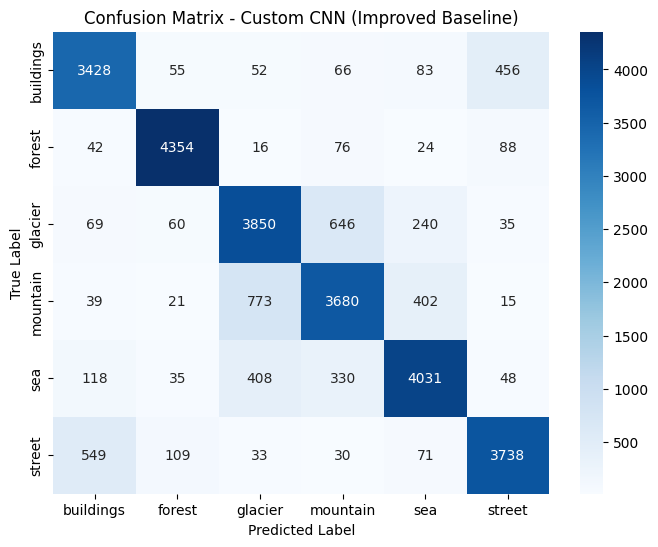

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_custom.parameters(), lr=0.0008)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10
model_custom, preds_custom, labels_custom = train_model(model_custom, criterion, optimizer, scheduler, num_epochs=num_epochs)


acc_custom = accuracy_score(labels_custom, preds_custom)
f1_custom = f1_score(labels_custom, preds_custom, average='weighted')
print(f'Custom CNN Improved Baseline Validation Accuracy: {acc_custom:.4f}')
print(f'Custom CNN Improved Baseline Validation F1 Score: {f1_custom:.4f}')

cm_custom = confusion_matrix(labels_custom, preds_custom)
plt.figure(figsize=(8,6))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN (Improved Baseline)')
plt.show()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 3
model_transformer, preds_transformer, labels_transformer = train_model(model_transformer,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       num_epochs=num_epochs)

acc_transformer = accuracy_score(labels_transformer, preds_transformer)
f1_transformer = f1_score(labels_transformer, preds_transformer, average='weighted')
print(f'Custom Transformer Improved Baseline Validation Accuracy: {acc_transformer:.4f}')
print(f'Custom Transformer Improved Baseline Validation F1 Score: {f1_transformer:.4f}')

cm_transformer = confusion_matrix(labels_transformer, preds_transformer)
plt.figure(figsize=(8,6))
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom Transformer (Improved Baseline)')
plt.show()

Epoch 1/3
----------
train Loss: 1.3621 Acc: 0.4364
val Loss: 1.2046 Acc: 0.5094

Epoch 2/3
----------
train Loss: 1.1742 Acc: 0.5064
val Loss: 1.1693 Acc: 0.5287

Epoch 3/3
----------
train Loss: 1.0741 Acc: 0.5561
val Loss: 1.0458 Acc: 0.5682

Обучение завершено за 4m 41s
Лучшая точность на валидации: 0.5682
Custom Transformer Improved Baseline Validation Accuracy: 0.5354
Custom Transformer Improved Baseline Validation F1 Score: 0.5025


NameError: name 'plt' is not defined

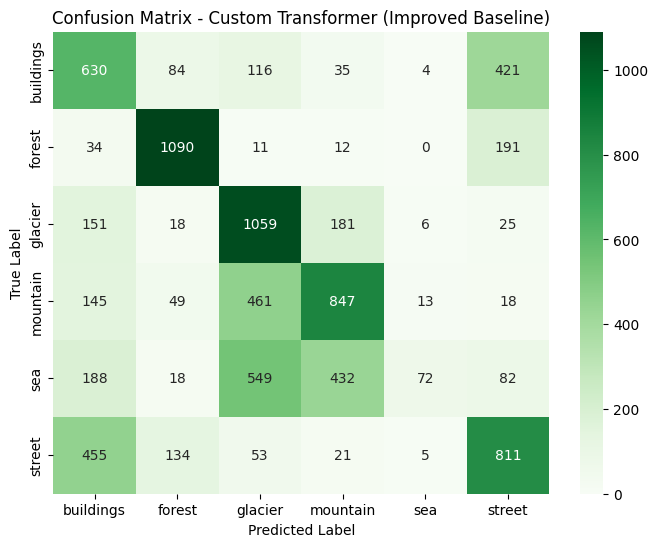

In [11]:
import matplotlib.pyplot as plt

cm_transformer = confusion_matrix(labels_transformer, preds_transformer)
plt.figure(figsize=(8,6))
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom Transformer (Improved Baseline)')
plt.show()

Как можно заметить, на улучшенном бейзлайне мои модели показали существенный прирост в точности и f1-score, и если затратить еще больше времени на обучении, то можно увеличить точность особенно у трансформерной модели

**В ходе выполнения лабораторной работы была решена задача многоклассовой классификации изображений на основе датасета Intel Image Classification, содержащего 6 категорий природных и городских сцен. Лабораторная работа продемонстрировала, что грамотный выбор модели, аугментация данных и оптимизация гиперпараметров являются ключевыми факторами для достижения высокого качества классификации. Предобученные модели являются отличной отправной точкой, однако самостоятельная реализация архитектур позволяет получить более глубокое понимание и гибкость в подходе к решению практических задач**